<a id="1"></a> <br>
# Imports and Dataset

In [1]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from keras.models import Sequential, Model
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd 
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import os
from keras import backend as K
import glob
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.optimizers import Adam, SGD, RMSprop
import tensorflow as tf 
from keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D
from keras.layers import Activation, Dropout, BatchNormalization, Flatten, Dense, AvgPool2D,MaxPool2D

<a id="2"></a> <br>
# Preparing Data for CNN

In [2]:
DATASET_DIR = "/Users/yeezy/Documents/Covid - Normal - Test"

os.listdir(DATASET_DIR)

['.DS_Store',
 'test',
 'CNN_simp_Test final.ipynb',
 'CNN_Mid_Change_Arch.ipynb',
 'Lime',
 'Old NB',
 'split_dataset.py',
 'CNN_Mid_Lime.ipynb',
 'CNN_Mid_Test.ipynb',
 'train',
 'Normal',
 '.ipynb_checkpoints',
 'Mid.ipynb',
 'Transfer Learning.ipynb',
 'MID_FOR_CAM.hdf5',
 'COVID',
 'MID_CNN_MODEL.hdf5',
 '.idea',
 'CAM_CNN.ipynb']

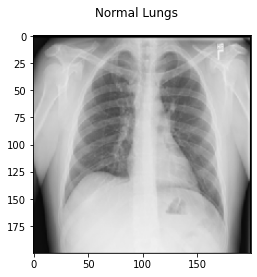

In [3]:
normal_images = []
count = 0

for img_path in glob.glob(DATASET_DIR + "/Normal/*"):
    count += 1
    normal_images.append(image.load_img(str(img_path), target_size = (200,200,3)))
    
fig = plt.figure()
fig.suptitle("Normal Lungs")
plt.imshow(normal_images[0], cmap="gray")
plt.show()

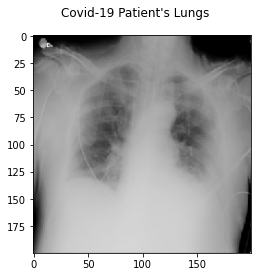

In [4]:
covid_images = []
for img_path in glob.glob(DATASET_DIR + "/COVID/*"): 
    covid_images.append(image.load_img(str(img_path), target_size = (200,200,3)))
    
fig = plt.figure()
fig.suptitle("Covid-19 Patient's Lungs ")
plt.imshow(covid_images[0], cmap = "gray")
plt.show()

In [5]:
print(str(len(normal_images))+" normal patient images")
print(str(len(covid_images))+" covid patient images")

3616 normal patient images
3616 covid patient images


In [6]:
images_together = []

for i in normal_images:
    images_together.append(img_to_array(i))
    
for i in covid_images:
    images_together.append(img_to_array(i))
    
targets = np.zeros(len(images_together))
targets[:len(normal_images)-1] = 1 # normal-> 1, covid-19-> 0

In [7]:
print("image list length: ",len(images_together))
print("target list length: ",len(targets))

image list length:  7232
target list length:  7232


In [8]:
targets = np.array(targets)
print("targets: ",targets.shape)
targets = targets.reshape(-1,1)
print("new shape of targets: ",targets.shape)

targets:  (7232,)
new shape of targets:  (7232, 1)


In [9]:
images_together = np.array(images_together)
print("shape of images together: ",images_together.shape)

shape of images together:  (7232, 200, 200, 3)


In [10]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(images_together, targets, test_size=0.2, stratify=targets)

images_together = np.concatenate((X_train, X_val))
targets = np.concatenate((y_train, y_val))

<a id="3"></a> <br>
# CNN Model

In [11]:
# IMG_W = 256
# IMG_H = 256
# CHANNELS = 3

# INPUT_SHAPE = (IMG_W, IMG_H, CHANNELS)
NB_CLASSES = 2
EPOCHS = 100
BATCH_SIZE = 40

In [14]:
callbacks = [ 
    EarlyStopping(monitor = 'loss', patience = 7), 
    ReduceLROnPlateau(monitor = 'loss', patience = 7), 
    ModelCheckpoint('MID_CNN_MODEL.hdf5', monitor='loss' , save_best_only=True) # saving the best model
]

In [15]:
def model1():
    return Sequential([
        Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same', input_shape = (200,200,3)),
        Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.2),
        
        
        Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.2),
        
        
        Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.2),
        
        Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.2),
        
        
        
        Flatten(),
       
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.4),
        
        
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),
        
        Dense(1, activation = "sigmoid")
        
    ])

In [16]:
model2 = model1()
model2.compile(loss='binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])
model2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 200, 200, 16)      448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 200, 200, 16)      2320      
_________________________________________________________________
batch_normalization (BatchNo (None, 200, 200, 16)      64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 100, 100, 16)      0         
_________________________________________________________________
dropout (Dropout)            (None, 100, 100, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 100, 100, 64)      9280      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 100, 100, 64)      3

In [17]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                  shear_range = 0.2,
                                  zoom_range = 0.2,
                                  horizontal_flip = True,
                                  validation_split = 0.2)


train_generator = train_datagen.flow(
images_together, targets,
batch_size = BATCH_SIZE,
subset = "training")

validation_generator = train_datagen.flow(
images_together, targets,
batch_size = BATCH_SIZE,
shuffle = False,
subset = "validation")

In [18]:
hist = model2.fit(
train_generator,
steps_per_epoch = (7232*0.8)//BATCH_SIZE,
validation_data = validation_generator,
validation_steps = (7232*0.2)// BATCH_SIZE,
epochs = EPOCHS,
callbacks = callbacks)

Epoch 1/100
144/144 [==============================] - 78s 528ms/step - loss: 0.6566 - accuracy: 0.6775 - val_loss: 3.6703 - val_accuracy: 0.5139
Epoch 2/100
144/144 [==============================] - 75s 522ms/step - loss: 0.4018 - accuracy: 0.8244 - val_loss: 0.7167 - val_accuracy: 0.5028
Epoch 3/100
144/144 [==============================] - 76s 528ms/step - loss: 0.3305 - accuracy: 0.8533 - val_loss: 0.9371 - val_accuracy: 0.5111
Epoch 4/100
144/144 [==============================] - 76s 524ms/step - loss: 0.2936 - accuracy: 0.8735 - val_loss: 1.1488 - val_accuracy: 0.5437
Epoch 5/100
144/144 [==============================] - 76s 522ms/step - loss: 0.2738 - accuracy: 0.8895 - val_loss: 0.7204 - val_accuracy: 0.6535
Epoch 6/100
144/144 [==============================] - 76s 525ms/step - loss: 0.2740 - accuracy: 0.8856 - val_loss: 0.9897 - val_accuracy: 0.6785
Epoch 7/100
144/144 [==============================] - 76s 523ms/step - loss: 0.2551 - accuracy: 0.8964 - val_loss: 0.8361 -

Epoch 57/100
144/144 [==============================] - 75s 521ms/step - loss: 0.0576 - accuracy: 0.9807 - val_loss: 0.1414 - val_accuracy: 0.9472
Epoch 58/100
144/144 [==============================] - 75s 522ms/step - loss: 0.0561 - accuracy: 0.9828 - val_loss: 0.1074 - val_accuracy: 0.9632
Epoch 59/100
144/144 [==============================] - 77s 531ms/step - loss: 0.0542 - accuracy: 0.9796 - val_loss: 0.0786 - val_accuracy: 0.9729
Epoch 60/100
144/144 [==============================] - 76s 523ms/step - loss: 0.0427 - accuracy: 0.9849 - val_loss: 0.1059 - val_accuracy: 0.9625
Epoch 61/100
144/144 [==============================] - 75s 522ms/step - loss: 0.0498 - accuracy: 0.9806 - val_loss: 0.0722 - val_accuracy: 0.9764
Epoch 62/100
144/144 [==============================] - 76s 524ms/step - loss: 0.0385 - accuracy: 0.9882 - val_loss: 0.0974 - val_accuracy: 0.9708
Epoch 63/100
144/144 [==============================] - 75s 522ms/step - loss: 0.0407 - accuracy: 0.9874 - val_loss: 0

<a id="3.1"></a> <br>
## Results

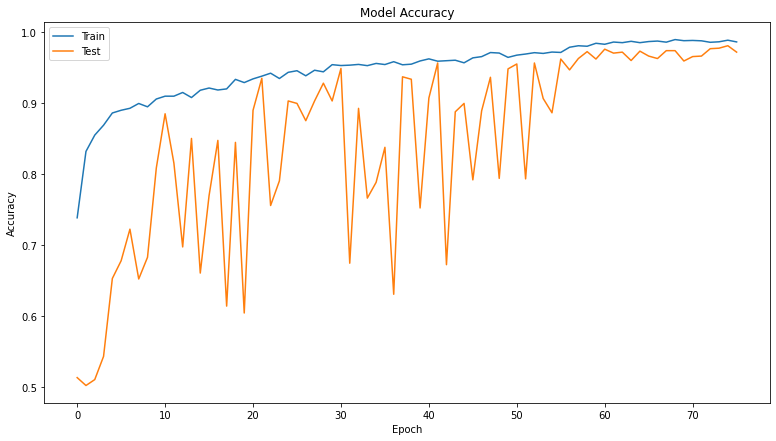

In [19]:
plt.figure(figsize = (13,7))
plt.plot(hist.history["accuracy"])
plt.plot(hist.history["val_accuracy"])
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train", "Test"], loc = "upper left")
plt.show()

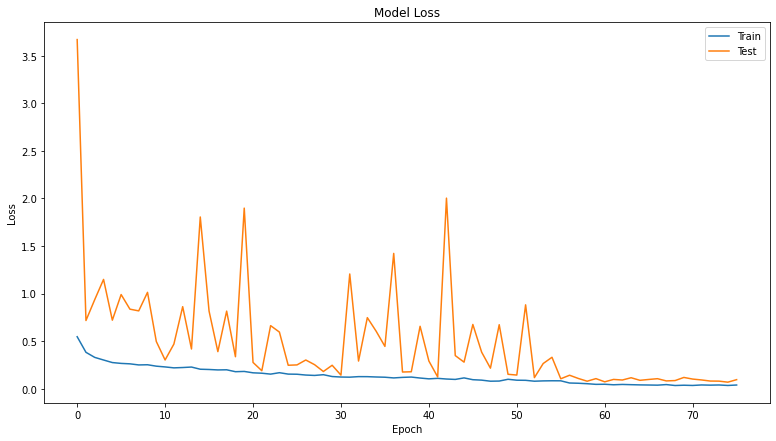

In [20]:
plt.figure(figsize = (13,7))
plt.plot(hist.history["loss"])
plt.plot(hist.history["val_loss"])
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train", "Test"], loc = "upper right")
plt.show()

In [21]:
print("Training Accuracy: "+str(np.round(hist.history["accuracy"][-1]*100,2))+"%")
print("Validation Accuracy: "+str(np.round(hist.history["val_accuracy"][-1]*100,2))+"%")

Training Accuracy: 98.66%
Validation Accuracy: 97.22%
